In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [16]:
# Load data with qualifying AND engineered features
# f1_results_features.csv has: qualifying data + driver_win_rate + team_reliability + race outcomes
f1_results = pd.read_csv("../data/f1_results_features.csv")
f1_laps = pd.read_csv("../data/f1_laps_features.csv")

print(f"Loaded {len(f1_results)} race results")
print(f"Columns: {list(f1_results.columns)}")


Loaded 180 race results
Columns: ['Year', 'Race', 'Driver', 'Team', 'Position', 'GridPosition', 'Points', 'Status', 'BestQualifyingTime', 'GapToPole', 'QualifyingPerformance', 'PositionChange', 'driver_win_rate', 'team_reliability', 'race_winner', 'podium_finish', 'points_finish']


In [17]:
f1_laps.head()

,Year,Race,Driver,Team,LapNumber,LapTime_seconds,Position,TireCompound,TireAge,PositionGroup,driver_win_rate,start_position,positions_gained,tire_degradation,race_phase,team_reliability
0,2025,16,VER,Red Bull Racing,1.0,87.159,1.0,MEDIUM,1.0,Top 5,0.0,1.0,0.0,-0.019,Early,94.444444
1,2025,16,VER,Red Bull Racing,2.0,84.859,2.0,MEDIUM,2.0,Top 5,0.0,1.0,-1.0,-2.300,Early,94.444444
2,2025,16,VER,Red Bull Racing,3.0,83.512,2.0,MEDIUM,3.0,Top 5,0.0,1.0,-1.0,-1.347,Early,94.444444
3,2025,16,VER,Red Bull Racing,4.0,83.262,1.0,MEDIUM,4.0,Top 5,0.0,1.0,0.0,-0.250,Early,94.444444
4,2025,16,VER,Red Bull Racing,5.0,83.588,1.0,MEDIUM,5.0,Top 5,0.0,1.0,0.0,0.326,Early,94.444444


In [18]:
f1_results.head()

,Year,Race,Driver,Team,Position,GridPosition,Points,Status,BestQualifyingTime,GapToPole,QualifyingPerformance,PositionChange,driver_win_rate,team_reliability,race_winner,podium_finish,points_finish
0,2025,16,M VERSTAPPEN,Red Bull Racing,1.0,1.0,25.0,Finished,78.792,0.000,5.0,0.0,66.666667,94.444444,1,1,1
1,2025,16,L NORRIS,McLaren,2.0,2.0,18.0,Finished,78.869,0.077,10.0,0.0,22.222222,83.333333,0,1,1
2,2025,16,O PIASTRI,McLaren,3.0,3.0,15.0,Finished,78.982,0.190,15.0,0.0,0.000000,83.333333,0,1,1
3,2025,16,C LECLERC,Ferrari,4.0,4.0,12.0,Finished,79.007,0.215,20.0,0.0,0.000000,88.888889,0,0,1
4,2025,16,G RUSSELL,Mercedes,5.0,5.0,10.0,Finished,79.157,0.365,30.0,0.0,11.111111,100.000000,0,0,1


In [19]:
# Predicting race winner using multiple models

# Enhanced features with qualifying (if available)
pre_race_features = ['Team', 'Position', 'GridPosition', 'driver_win_rate', 'team_reliability']

# Add qualifying features if available in dataset
if 'BestQualifyingTime' in f1_results.columns:
    pre_race_features.extend(['BestQualifyingTime', 'GapToPole', 'QualifyingPerformance'])
    print("✓ Using enhanced features with qualifying data")
else:
    print("⚠ Using basic features only - consider running data_cleaning.py for qualifying")

print(f"Total features: {len(pre_race_features)}")

# Check for missing values and handle them
print(f"\nMissing values before cleaning:")
print(f1_results[pre_race_features + ['race_winner']].isnull().sum())

# Drop rows with missing values in features or target
data_clean = f1_results[pre_race_features + ['race_winner']].dropna()
print(f"\nRows: {len(f1_results)} → {len(data_clean)} (removed {len(f1_results) - len(data_clean)} with NaN)")

X = data_clean[pre_race_features]
y = data_clean['race_winner']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Team']),
        ('num', 'passthrough', [f for f in pre_race_features if f != 'Team'])
    ]
)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced')
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {
    'accuracy': {},
    'f1': {}
}

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    
    model_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    cv_accuracy = cross_val_score(model_pipeline, X, y, cv=cv, scoring='accuracy')
    cv_f1 = cross_val_score(model_pipeline, X, y, cv=cv, scoring='f1')
    
    results['accuracy'][name] = cv_accuracy
    results['f1'][name] = cv_f1
    

    print(f"Cross validation accuracy: {cv_accuracy.mean():.4f} ± {cv_accuracy.std():.4f}")
    print(f"Cross validation F1 score: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
    
    model_pipeline.fit(X, y)

summary = pd.DataFrame({
    'Accuracy': {model: results['accuracy'][model].mean() for model in models},
    'F1 Score': {model: results['f1'][model].mean() for model in models}
})

import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing the cross-validation results
results_df = pd.DataFrame({
    'Model': [],
    'Metric': [],
    'Score': []
})

for name, model in models.items():
    for metric in ['accuracy', 'f1']:
        for score in results[metric][name]:
            results_df = pd.concat([results_df, pd.DataFrame({
                'Model': [name],
                'Metric': [metric],
                'Score': [score]
            })], ignore_index=True)

plt.figure(figsize=(12, 6))

# Accuracy plot


✓ Using enhanced features with qualifying data
Total features: 8

Missing values before cleaning:
Team                     0
Position                 0
GridPosition             0
driver_win_rate          0
team_reliability         0
BestQualifyingTime       0
GapToPole                0
QualifyingPerformance    1
race_winner              0
dtype: int64

Rows: 180 → 179 (removed 1 with NaN)

Evaluating Random Forest...
Cross validation accuracy: 1.0000 ± 0.0000
Cross validation F1 score: 1.0000 ± 0.0000

Evaluating Logistic Regression...
Cross validation accuracy: 0.9889 ± 0.0136
Cross validation F1 score: 0.8933 ± 0.1373

Evaluating Gradient Boosting...
Cross validation accuracy: 1.0000 ± 0.0000
Cross validation F1 score: 1.0000 ± 0.0000

Evaluating SVM...
Cross validation accuracy: 0.9219 ± 0.0565
Cross validation F1 score: 0.6133 ± 0.2115


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>


=== MODEL COMPARISON ===
                     Accuracy  F1 Score
Random Forest        1.000000  1.000000
Gradient Boosting    1.000000  1.000000
Logistic Regression  0.988889  0.893333
SVM                  0.921905  0.613333

Best model: Random Forest (F1: 1.0000)


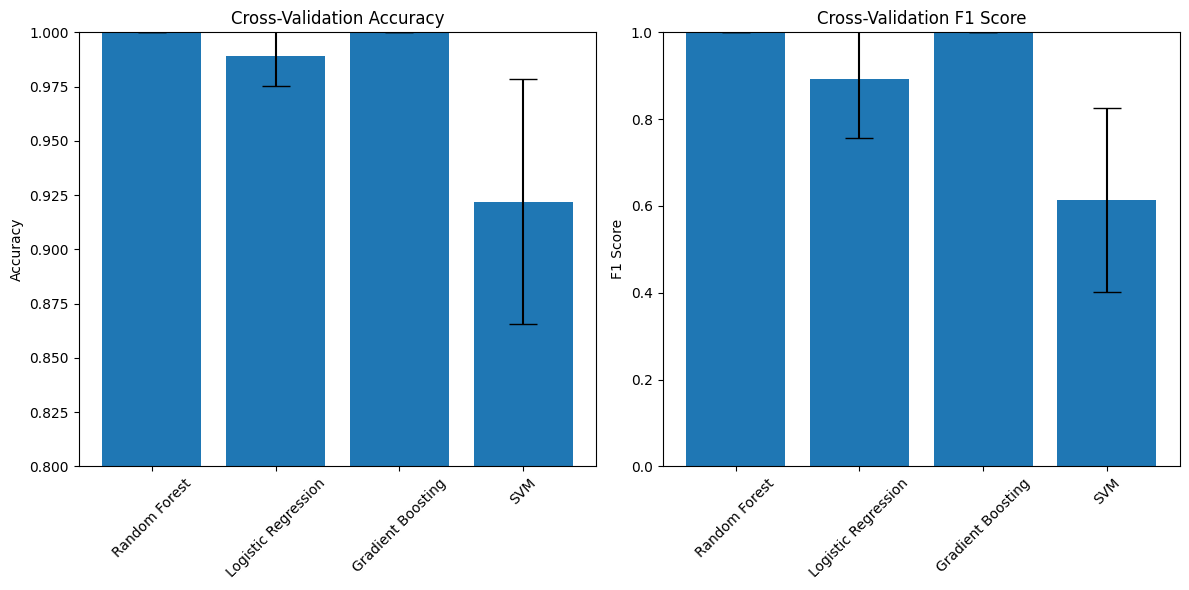

In [20]:
print("\n=== MODEL COMPARISON ===")
print(summary.sort_values('F1 Score', ascending=False))

# Select best model based on F1 score
best_model = summary['F1 Score'].idxmax()
print(f"\nBest model: {best_model} (F1: {summary.loc[best_model, 'F1 Score']:.4f})")

# Plot results
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
model_names = list(models.keys())
accuracy_means = [results['accuracy'][model].mean() for model in model_names]
accuracy_stds = [results['accuracy'][model].std() for model in model_names]

plt.bar(range(len(model_names)), accuracy_means, yerr=accuracy_stds, capsize=10)
plt.xticks(range(len(model_names)), model_names, rotation=45)
plt.title('Cross-Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # Adjust as needed


plt.subplot(1, 2, 2)
f1_means = [results['f1'][model].mean() for model in model_names]
f1_stds = [results['f1'][model].std() for model in model_names]

plt.bar(range(len(model_names)), f1_means, yerr=f1_stds, capsize=10)
plt.xticks(range(len(model_names)), model_names, rotation=45)
plt.title('Cross-Validation F1 Score')
plt.ylabel('F1 Score')
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

In [ ]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(n_estimators = 1000,
                            learning_rate=0.01,
                            max_depth=4,
                            random_state=42
                            )



pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_classifier)
])

# Train with early stopping
pipeline.fit(X, y)

print(f"Training complete")

Training complete


In [22]:
import pickle

pickle.dump(xgb_classifier , open('../models/xgb_racewin.pk1' , 'wb'))
pickle.dump(pipeline, open('../models/xgb_racewin_pipeline.pk1', 'wb'))